# House Price regression project

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

### Target - SalePrice

# Step 1 - Data Ingestion

In [2]:
import pandas as pd

df = pd.read_csv("training_set.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Step 2 -  Perform basic data quality checks

In [3]:
df.shape

(1460, 81)

In [4]:
df.duplicated().sum()

np.int64(0)

In [5]:
m = df.isna().sum()
m[m > 0]

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [6]:
per_missing = m[m > 0] / len(df)
per_missing

LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.597260
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

### Replace categorical missing values with constant strategy because some columns have lots of missing values in this data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Step 3 - Seperate X and Y(SalePrice)

In [8]:
X = df.drop(columns = ["Id", "SalePrice"])
Y = df["SalePrice"]

In [9]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [10]:
Y.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [11]:
# Remove high cardinality columns
def get_high_cardinality(X: pd.DataFrame, threshold: float = 0.9) -> list[str]:
    unique_count = X.select_dtypes(include="object").nunique()
    cardinality = unique_count / len(X)
    print(cardinality)
    high_cardinality = cardinality[cardinality >=  threshold]
    return high_cardinality.index.tolist()

In [12]:
high_cardinality = get_high_cardinality(X)

MSZoning         0.003425
Street           0.001370
Alley            0.001370
LotShape         0.002740
LandContour      0.002740
Utilities        0.001370
LotConfig        0.003425
LandSlope        0.002055
Neighborhood     0.017123
Condition1       0.006164
Condition2       0.005479
BldgType         0.003425
HouseStyle       0.005479
RoofStyle        0.004110
RoofMatl         0.005479
Exterior1st      0.010274
Exterior2nd      0.010959
MasVnrType       0.002055
ExterQual        0.002740
ExterCond        0.003425
Foundation       0.004110
BsmtQual         0.002740
BsmtCond         0.002740
BsmtExposure     0.002740
BsmtFinType1     0.004110
BsmtFinType2     0.004110
Heating          0.004110
HeatingQC        0.003425
CentralAir       0.001370
Electrical       0.003425
KitchenQual      0.002740
Functional       0.004795
FireplaceQu      0.003425
GarageType       0.004110
GarageFinish     0.002055
GarageQual       0.003425
GarageCond       0.003425
PavedDrive       0.002055
PoolQC      

In [13]:
high_cardinality

[]

# There are no high cardinality features in this data hence no need to drop any further features

# Step 4 - Train Test Split

In [14]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [15]:
xtrain.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
254,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1066,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
638,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal
799,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal
380,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


In [16]:
ytrain.head()

254     145000
1066    178000
638      85000
799     175000
380     127000
Name: SalePrice, dtype: int64

In [17]:
xtest.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
892,20,RL,70.0,8414,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,2,2006,WD,Normal
1105,60,RL,98.0,12256,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
413,30,RM,56.0,8960,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,3,2010,WD,Normal
522,50,RM,50.0,5000,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,10,2006,WD,Normal
1036,20,RL,89.0,12898,Pave,NaN,IR1,HLS,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal


In [18]:
ytest.head()

892     154500
1105    325000
413     115000
522     159000
1036    315500
Name: SalePrice, dtype: int64

In [19]:
xtrain.shape

(1168, 79)

In [20]:
ytrain.shape

(1168,)

In [21]:
xtest.shape

(292, 79)

In [22]:
ytest.shape

(292,)

# Step 5 - Preprocessing on X
1. numerical features : SimpleImputer (mean, median) -> StandardScaler
2. categorical features : SimpleImputer(constant) -> OrdinalEncoder -> StandardScaler

In [23]:
cat_cols = X.select_dtypes(include="object").columns.tolist()
cat_cols

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [24]:
num_cols = X.select_dtypes(include="number").columns.tolist()
num_cols

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [26]:
num_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

In [27]:
cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="not_available"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
    StandardScaler()
)

In [28]:
pre = ColumnTransformer(
    [
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ]
).set_output(transform="pandas")
pre.fit(xtrain, ytrain)

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [29]:
xtrain_pre = pre.transform(xtrain)
xtest_pre = pre.transform(xtest)

In [30]:
xtrain_pre.head()

,num__MSSubClass,num__LotFrontage,num__LotArea,num__OverallQual,num__OverallCond,num__YearBuilt,num__YearRemodAdd,num__MasVnrArea,num__BsmtFinSF1,num__BsmtFinSF2,...,cat__GarageType,cat__GarageFinish,cat__GarageQual,cat__GarageCond,cat__PavedDrive,cat__PoolQC,cat__Fence,cat__MiscFeature,cat__SaleType,cat__SaleCondition
254,-0.866764,-0.012468,-0.212896,-0.820445,0.372217,-0.455469,-1.346063,-0.597889,1.037269,-0.285504,...,-0.768510,-0.309634,0.111726,0.072237,0.292826,0.066503,0.467615,0.197298,0.316662,0.201772
1066,0.074110,-0.502357,-0.265245,-0.088934,1.268609,0.718609,0.439214,-0.597889,-0.971996,-0.285504,...,-0.768510,-0.309634,0.111726,0.072237,0.292826,0.066503,0.467615,0.197298,0.316662,0.201772
638,-0.631546,-0.146074,-0.177841,-0.820445,1.268609,-1.988293,-1.683818,-0.597889,-0.971996,-0.285504,...,1.824268,1.929699,1.665247,1.829998,-1.707294,0.066503,-1.343907,0.197298,0.316662,0.201772
799,-0.161109,-0.457822,-0.324474,-0.820445,1.268609,-1.107734,-1.683818,0.861522,0.267995,-0.285504,...,1.305713,0.810033,0.111726,0.072237,0.292826,0.066503,-1.343907,0.197298,0.316662,0.201772
380,-0.161109,-0.903175,-0.529035,-0.820445,0.372217,-1.531707,-1.683818,-0.597889,-0.496920,-0.285504,...,1.305713,0.810033,0.111726,0.072237,0.292826,0.066503,0.467615,0.197298,0.316662,0.201772


In [31]:
xtest_pre.head()

,num__MSSubClass,num__LotFrontage,num__LotArea,num__OverallQual,num__OverallCond,num__YearBuilt,num__YearRemodAdd,num__MasVnrArea,num__BsmtFinSF1,num__BsmtFinSF2,...,cat__GarageType,cat__GarageFinish,cat__GarageQual,cat__GarageCond,cat__PavedDrive,cat__PoolQC,cat__Fence,cat__MiscFeature,cat__SaleType,cat__SaleCondition
892,-0.866764,-0.012468,-0.211594,-0.088934,2.165000,-0.259789,0.873470,-0.597889,0.472844,-0.285504,...,-0.768510,-0.309634,0.111726,0.072237,0.292826,0.066503,-1.343907,0.197298,0.316662,0.201772
1105,0.074110,1.234520,0.145643,1.374088,-0.524174,0.751222,0.487465,1.498567,1.276986,-0.285504,...,-0.768510,-0.309634,0.111726,0.072237,0.292826,0.066503,0.467615,0.197298,0.316662,0.201772
413,-0.631546,-0.635963,-0.160826,-0.820445,0.372217,-1.433867,-1.683818,-0.597889,-0.971996,-0.285504,...,1.305713,0.810033,0.111726,0.072237,0.292826,0.066503,0.467615,0.197298,0.316662,0.201772
522,-0.161109,-0.903175,-0.529035,-0.088934,1.268609,-0.781602,-1.683818,-0.597889,-0.102477,-0.285504,...,1.305713,0.810033,0.111726,0.072237,0.292826,0.066503,0.467615,0.197298,0.316662,0.201772
1036,-0.866764,0.833703,0.205338,2.105599,-0.524174,1.175195,1.114724,-0.192497,1.255193,-0.285504,...,-0.768510,-1.429300,0.111726,0.072237,0.292826,0.066503,0.467615,0.197298,0.316662,0.201772


# Step 6 - Experiment with different models
1. Baseline - LinearRegression
2. Feature Selection 
3. Ridge on Feature Selection
4. Lasso on Feature Selection
5. Polynomial with lasso
6. Polynomial with Ridge

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

baseline = LinearRegression()
scores = cross_val_score(baseline, xtrain_pre, ytrain, cv=5, scoring="r2")
scores

array([0.78090972, 0.74639266, 0.65136957, 0.85971003, 0.23361077])

In [33]:
scores.mean()

np.float64(0.6543985517310899)

In [34]:
scores.std()

np.float64(0.2207679016296021)

In [35]:
baseline.fit(xtrain_pre, ytrain)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [36]:
baseline.intercept_

np.float64(181441.5419520549)

In [37]:
baseline.coef_

array([ -5556.78761318,  -5786.31223403,   3905.96842218,  14865.60745657,
         5581.00360892,   6807.65429271,   1133.22814257,   6380.83549522,
         1417.31330468,    594.38270944,  -1949.6092056 ,   -284.89682549,
         9601.92192222,   6835.95377351,  -1017.5189039 ,  12716.57170925,
         3785.06230339,   -818.05948511,   1400.51175212,   -453.19458843,
        -1355.15803024,  -2692.15534077,   6435.83458446,   2819.13548117,
         -270.53503852,   8995.849545  ,   -445.78211854,   2426.46605199,
           34.96048297,   -686.18879548,   1529.36011806,   2528.54737443,
       -14457.01074505,    322.05519657,   -536.62984697,   -764.69269187,
        -1273.0343585 ,   1096.03321018,   1803.71848335,  -1542.6906396 ,
         2129.27563058,  -1678.59731744,     24.55390244,   2900.2760924 ,
         2495.17135031,   -713.15559588,  -2676.83433067,  -2760.49780711,
        -1707.86724126,   2059.86773076,   3310.22170864,  -4813.49994168,
         2950.91415561,  

In [38]:
r2_train = baseline.score(xtrain_pre, ytrain)
print(f"Train R2 : {r2_train:.4f}")

Train R2 : 0.8551


In [39]:
r2_test = baseline.score(xtest_pre, ytest)
print(f"Test R2 : {r2_test:.4f}")

Test R2 : 0.8444


In [40]:
gen_err = abs(r2_train - r2_test)
print(f"Generalization error : {gen_err:.4f}")

Generalization error : 0.0107


In [41]:
# Intializing a blank results list
results = []

def evaluate_and_log_model(results, model, xtrain, ytrain, xtest, ytest, description):
    # Cross validate data on train
    scores = cross_val_score(model, xtrain, ytrain, cv=5, scoring="r2")
    mean_score = scores.mean().round(4)
    std_score = scores.std().round(4)
    # Fit the model
    model.fit(xtrain, ytrain)
    # Evalutate r2 score on train and test
    r2_train = round(model.score(xtrain, ytrain), 4)
    r2_test = round(model.score(xtest, ytest), 4)
    # Generalization error
    gen_err = abs(round(r2_train - r2_test, 4))
    # Save above results in a dictionary
    r = {
        "description": description,
        "name": type(model).__name__,
        "cv_mean": mean_score,
        "cv_std": std_score,
        "r2_train": r2_train,
        "r2_test": r2_test,
        "gen_err": gen_err
    }
    print(r)
    results.append(r)
    return model

In [42]:
baseline_logged = evaluate_and_log_model(
    results, baseline, xtrain_pre, ytrain, xtest_pre, ytest,
    description="Baseline Linear Regression"
)

{'description': 'Baseline Linear Regression', 'name': 'LinearRegression', 'cv_mean': np.float64(0.6544), 'cv_std': np.float64(0.2208), 'r2_train': 0.8551, 'r2_test': 0.8444, 'gen_err': 0.0107}


# Apply feature selection

In [43]:
from sklearn.feature_selection import SequentialFeatureSelector

sel = SequentialFeatureSelector(LinearRegression(), n_features_to_select="auto", direction="forward")
sel.fit(xtrain_pre, ytrain)

,estimator,LinearRegression()
,n_features_to_select,'auto'
,tol,None
,direction,'forward'
,scoring,None
,cv,5
,n_jobs,None
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [44]:
sel_cols = sel.get_feature_names_out()
sel_cols

array(['num__MSSubClass', 'num__LotFrontage', 'num__LotArea',
       'num__OverallQual', 'num__OverallCond', 'num__YearBuilt',
       'num__BsmtUnfSF', 'num__GrLivArea', 'num__BsmtFullBath',
       'num__BsmtHalfBath', 'num__GarageCars', 'num__WoodDeckSF',
       'num__3SsnPorch', 'num__ScreenPorch', 'num__MiscVal',
       'cat__MSZoning', 'cat__Alley', 'cat__LotShape', 'cat__LandContour',
       'cat__Utilities', 'cat__LandSlope', 'cat__Neighborhood',
       'cat__RoofStyle', 'cat__Exterior1st', 'cat__MasVnrType',
       'cat__ExterQual', 'cat__BsmtQual', 'cat__BsmtCond',
       'cat__BsmtExposure', 'cat__BsmtFinType1', 'cat__CentralAir',
       'cat__Electrical', 'cat__KitchenQual', 'cat__Functional',
       'cat__FireplaceQu', 'cat__GarageQual', 'cat__PavedDrive',
       'cat__MiscFeature', 'cat__SaleCondition'], dtype=object)

In [45]:
len(sel_cols)

39

In [46]:
xtrain_pre_sel = sel.transform(xtrain_pre)
xtest_pre_sel = sel.transform(xtest_pre)

In [47]:
xtrain_pre_sel

array([[-0.8667643 , -0.01246836, -0.21289571, ...,  0.29282582,
         0.19729838,  0.20177167],
       [ 0.07410996, -0.50235683, -0.26524463, ...,  0.29282582,
         0.19729838,  0.20177167],
       [-0.63154574, -0.14607431, -0.17784146, ..., -1.7072944 ,
         0.19729838,  0.20177167],
       ...,
       [-0.8667643 , -0.45782152, -0.23409563, ..., -3.70741463,
         0.19729838,  0.20177167],
       [-0.16110861, -0.6804981 , -0.28337613, ...,  0.29282582,
         0.19729838,  0.20177167],
       [ 1.48542135, -0.76956873, -0.65139925, ...,  0.29282582,
         0.19729838,  0.20177167]], shape=(1168, 39))

In [48]:
xtrain_pre_sel.shape

(1168, 39)

In [49]:
xtest_pre_sel

array([[-0.8667643 , -0.01246836, -0.21159396, ...,  0.29282582,
         0.19729838,  0.20177167],
       [ 0.07410996,  1.23452047,  0.14564323, ...,  0.29282582,
         0.19729838,  0.20177167],
       [-0.63154574, -0.63596278, -0.16082574, ...,  0.29282582,
         0.19729838,  0.20177167],
       ...,
       [ 0.07410996, -0.32421557, -0.23158511, ...,  0.29282582,
         0.19729838,  0.20177167],
       [ 0.30932853, -0.45782152, -0.14929596, ..., -1.7072944 ,
         0.19729838,  0.20177167],
       [-0.8667643 , -0.01246836, -0.2389307 , ...,  0.29282582,
         0.19729838,  0.20177167]], shape=(292, 39))

In [50]:
xtest_pre_sel.shape

(292, 39)

## Create a seperate model on selected features

In [51]:
feat_sel_model = evaluate_and_log_model(
    results, LinearRegression(), xtrain_pre_sel, ytrain, xtest_pre_sel, ytest,
    description="LinearRegression on Selected Features"
)

{'description': 'LinearRegression on Selected Features', 'name': 'LinearRegression', 'cv_mean': np.float64(0.8243), 'cv_std': np.float64(0.0541), 'r2_train': 0.8397, 'r2_test': 0.8344, 'gen_err': 0.0053}


In [52]:
results

[{'description': 'Baseline Linear Regression',
  'name': 'LinearRegression',
  'cv_mean': np.float64(0.6544),
  'cv_std': np.float64(0.2208),
  'r2_train': 0.8551,
  'r2_test': 0.8444,
  'gen_err': 0.0107},
 {'description': 'LinearRegression on Selected Features',
  'name': 'LinearRegression',
  'cv_mean': np.float64(0.8243),
  'cv_std': np.float64(0.0541),
  'r2_train': 0.8397,
  'r2_test': 0.8344,
  'gen_err': 0.0053}]

# Ridge on Selected features

In [53]:
alphas_list = [0.01, 0.1, 1, 10, 50, 100, 500, 1000, 5000, 10000]
params = {
    "alpha":alphas_list
}

In [54]:
params

{'alpha': [0.01, 0.1, 1, 10, 50, 100, 500, 1000, 5000, 10000]}

In [55]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge1 = Ridge(random_state=42)
# n_jobs = -1 will utilize all cpu cores for tuning
gscv_ridge = GridSearchCV(ridge1, param_grid=params, cv=5, scoring="r2", n_jobs=-1)
gscv_ridge.fit(xtrain_pre_sel, ytrain)

,estimator,Ridge(random_state=42)
,param_grid,"{'alpha': [0.01, 0.1, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,50


In [56]:
gscv_ridge.best_params_

{'alpha': 50}

In [57]:
gscv_ridge.best_score_

np.float64(0.8255300177058871)

In [58]:
best_ridge = gscv_ridge.best_estimator_
best_ridge

,alpha,50
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,42


In [59]:
ridge_sel = evaluate_and_log_model(
    results, best_ridge, xtrain_pre_sel, ytrain, xtest_pre_sel, ytest,
    description="Ridge on selected features"
)

{'description': 'Ridge on selected features', 'name': 'Ridge', 'cv_mean': np.float64(0.8255), 'cv_std': np.float64(0.0516), 'r2_train': 0.8392, 'r2_test': 0.8335, 'gen_err': 0.0057}


# Lasso On Selected features

In [60]:
from sklearn.linear_model import Lasso

lasso1 = Lasso(random_state=42)
gscv_lasso = GridSearchCV(lasso1, param_grid=params, cv=5, scoring="r2", n_jobs=-1)
gscv_lasso.fit(xtrain_pre_sel, ytrain)

,estimator,Lasso(random_state=42)
,param_grid,"{'alpha': [0.01, 0.1, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,50


In [61]:
gscv_lasso.best_params_

{'alpha': 50}

In [62]:
gscv_lasso.best_score_

np.float64(0.8242814966863088)

In [63]:
best_lasso = gscv_lasso.best_estimator_
best_lasso

,alpha,50
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,42
,selection,'cyclic'


In [64]:
lasso_sel = evaluate_and_log_model(
    results, best_lasso, xtrain_pre_sel, ytrain, xtest_pre_sel, ytest,
    description="Lasso on selected features"
)

{'description': 'Lasso on selected features', 'name': 'Lasso', 'cv_mean': np.float64(0.8243), 'cv_std': np.float64(0.0543), 'r2_train': 0.8397, 'r2_test': 0.8346, 'gen_err': 0.0051}


# Polynomial Ridge

In [65]:
from sklearn.preprocessing import PolynomialFeatures

poly_ridge = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    Ridge(random_state=42)
)

In [66]:
params2 = {
    "ridge__alpha": alphas_list
}
params2

{'ridge__alpha': [0.01, 0.1, 1, 10, 50, 100, 500, 1000, 5000, 10000]}

In [67]:
gscv_poly_ridge = GridSearchCV(poly_ridge, param_grid=params2, cv=5, scoring="r2", n_jobs=-1)
gscv_poly_ridge.fit(xtrain_pre_sel, ytrain)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'ridge__alpha': [0.01, 0.1, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,degree,2


In [68]:
gscv_poly_ridge.best_params_

{'ridge__alpha': 500}

In [69]:
gscv_poly_ridge.best_score_

np.float64(0.7697875151287542)

In [70]:
best_poly_ridge = gscv_poly_ridge.best_estimator_
best_poly_ridge

,steps,"[('polynomialfeatures', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,degree,2
,interaction_only,False
,include_bias,False
,order,'C'
,alpha,500
,fit_intercept,True
,copy_X,True


In [71]:
poly_ridge_sel = evaluate_and_log_model(
    results, best_poly_ridge, xtrain_pre_sel, ytrain, xtest_pre_sel, ytest,
    description="Polynomial Ridge on selected features"
)

{'description': 'Polynomial Ridge on selected features', 'name': 'Pipeline', 'cv_mean': np.float64(0.7698), 'cv_std': np.float64(0.0411), 'r2_train': 0.9293, 'r2_test': 0.8224, 'gen_err': 0.1069}


# Polynomial with Lasso

In [72]:
poly_lasso = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    Lasso(random_state=42)
)

In [73]:
params3 = {
    "lasso__alpha": alphas_list
}
params3

{'lasso__alpha': [0.01, 0.1, 1, 10, 50, 100, 500, 1000, 5000, 10000]}

In [74]:
gscv_poly_lasso = GridSearchCV(
    poly_lasso, param_grid=params3, cv=5, scoring="r2", n_jobs=-1
)
gscv_poly_lasso.fit(xtrain_pre_sel, ytrain)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'lasso__alpha': [0.01, 0.1, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,degree,2


In [75]:
gscv_poly_lasso.best_params_

{'lasso__alpha': 1000}

In [76]:
gscv_poly_lasso.best_score_

np.float64(0.8424220917443414)

In [77]:
best_poly_lasso = gscv_poly_lasso.best_estimator_
best_poly_lasso

,steps,"[('polynomialfeatures', ...), ('lasso', ...)]"
,transform_input,None
,memory,None
,verbose,False
,degree,2
,interaction_only,False
,include_bias,False
,order,'C'
,alpha,1000
,fit_intercept,True
,precompute,False


In [78]:
poly_lasso_sel = evaluate_and_log_model(
    results, best_poly_lasso, xtrain_pre_sel, ytrain, xtest_pre_sel, ytest,
    description="Polynomial Lasso on selected features"
)

{'description': 'Polynomial Lasso on selected features', 'name': 'Pipeline', 'cv_mean': np.float64(0.8424), 'cv_std': np.float64(0.0587), 'r2_train': 0.9199, 'r2_test': 0.863, 'gen_err': 0.0569}


In [79]:
results

[{'description': 'Baseline Linear Regression',
  'name': 'LinearRegression',
  'cv_mean': np.float64(0.6544),
  'cv_std': np.float64(0.2208),
  'r2_train': 0.8551,
  'r2_test': 0.8444,
  'gen_err': 0.0107},
 {'description': 'LinearRegression on Selected Features',
  'name': 'LinearRegression',
  'cv_mean': np.float64(0.8243),
  'cv_std': np.float64(0.0541),
  'r2_train': 0.8397,
  'r2_test': 0.8344,
  'gen_err': 0.0053},
 {'description': 'Ridge on selected features',
  'name': 'Ridge',
  'cv_mean': np.float64(0.8255),
  'cv_std': np.float64(0.0516),
  'r2_train': 0.8392,
  'r2_test': 0.8335,
  'gen_err': 0.0057},
 {'description': 'Lasso on selected features',
  'name': 'Lasso',
  'cv_mean': np.float64(0.8243),
  'cv_std': np.float64(0.0543),
  'r2_train': 0.8397,
  'r2_test': 0.8346,
  'gen_err': 0.0051},
 {'description': 'Polynomial Ridge on selected features',
  'name': 'Pipeline',
  'cv_mean': np.float64(0.7698),
  'cv_std': np.float64(0.0411),
  'r2_train': 0.9293,
  'r2_test': 0.8

# Show evaluatation results in dataframe

In [80]:
eval_res = pd.DataFrame(results)
eval_res

,description,name,cv_mean,cv_std,r2_train,r2_test,gen_err
0,Baseline Linear Regression,LinearRegression,0.6544,0.2208,0.8551,0.8444,0.0107
1,LinearRegression on Selected Features,LinearRegression,0.8243,0.0541,0.8397,0.8344,0.0053
2,Ridge on selected features,Ridge,0.8255,0.0516,0.8392,0.8335,0.0057
3,Lasso on selected features,Lasso,0.8243,0.0543,0.8397,0.8346,0.0051
4,Polynomial Ridge on selected features,Pipeline,0.7698,0.0411,0.9293,0.8224,0.1069
5,Polynomial Lasso on selected features,Pipeline,0.8424,0.0587,0.9199,0.8630,0.0569


In [81]:
eval_res_sort = eval_res.sort_values(by = "gen_err")
eval_res_sort

,description,name,cv_mean,cv_std,r2_train,r2_test,gen_err
3,Lasso on selected features,Lasso,0.8243,0.0543,0.8397,0.8346,0.0051
1,LinearRegression on Selected Features,LinearRegression,0.8243,0.0541,0.8397,0.8344,0.0053
2,Ridge on selected features,Ridge,0.8255,0.0516,0.8392,0.8335,0.0057
0,Baseline Linear Regression,LinearRegression,0.6544,0.2208,0.8551,0.8444,0.0107
5,Polynomial Lasso on selected features,Pipeline,0.8424,0.0587,0.9199,0.8630,0.0569
4,Polynomial Ridge on selected features,Pipeline,0.7698,0.0411,0.9293,0.8224,0.1069


In [90]:
eval_res_sort.to_csv("evaluation.csv", index=False)

# From above results it is cleare Lasso on selected features have lowest generalization error and cross validation, train and test results are more than 0.8

In [82]:
lasso_sel

,alpha,50
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,42
,selection,'cyclic'


# Out of sample prediction

In [83]:
xnew = pd.read_csv("testing_set.csv")
xnew

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [84]:
xnew_pre = pre.transform(xnew)
xnew_pre.head()

,num__MSSubClass,num__LotFrontage,num__LotArea,num__OverallQual,num__OverallCond,num__YearBuilt,num__YearRemodAdd,num__MasVnrArea,num__BsmtFinSF1,num__BsmtFinSF2,...,cat__GarageType,cat__GarageFinish,cat__GarageQual,cat__GarageCond,cat__PavedDrive,cat__PoolQC,cat__Fence,cat__MiscFeature,cat__SaleType,cat__SaleCondition
0,-0.866764,0.432885,0.086693,-0.820445,0.372217,-0.325016,-1.153060,-0.597889,0.047891,0.625025,...,-0.76851,0.810033,0.111726,0.072237,0.292826,0.066503,-1.343907,0.197298,0.316662,0.201772
1,-0.866764,0.477420,0.332630,-0.088934,0.372217,-0.422856,-1.297812,0.027573,1.039448,-0.285504,...,-0.76851,0.810033,0.111726,0.072237,0.292826,0.066503,0.467615,-9.305568,0.316662,0.201772
2,0.074110,0.165673,0.291997,-0.820445,-0.524174,0.849062,0.632217,-0.597889,0.751787,-0.285504,...,-0.76851,-1.429300,0.111726,0.072237,0.292826,0.066503,-1.343907,0.197298,0.316662,0.201772
3,0.074110,0.343814,-0.066170,-0.088934,0.372217,0.881675,0.632217,-0.482062,0.339910,-0.285504,...,-0.76851,-1.429300,0.111726,0.072237,0.292826,0.066503,0.467615,0.197298,0.316662,0.201772
4,1.485421,-1.214922,-0.528570,1.374088,-0.524174,0.685996,0.342712,-0.597889,-0.398854,-0.285504,...,-0.76851,-0.309634,0.111726,0.072237,0.292826,0.066503,0.467615,0.197298,0.316662,0.201772


In [85]:
xnew_pre_sel = sel.transform(xnew_pre)
xnew_pre_sel

array([[-0.8667643 ,  0.43288479,  0.08669258, ...,  0.29282582,
         0.19729838,  0.20177167],
       [-0.8667643 ,  0.47742011,  0.33263021, ...,  0.29282582,
        -9.30556808,  0.20177167],
       [ 0.07410996,  0.1656729 ,  0.29199704, ...,  0.29282582,
         0.19729838,  0.20177167],
       ...,
       [-0.8667643 ,  3.99571004,  0.86569654, ...,  0.29282582,
         0.19729838, -3.50955605],
       [ 0.66215637, -0.36875089, -0.02311926, ...,  0.29282582,
        -4.55413485,  0.20177167],
       [ 0.07410996,  0.1656729 , -0.09880669, ...,  0.29282582,
         0.19729838,  0.20177167]], shape=(1459, 39))

In [86]:
preds = lasso_sel.predict(xnew_pre_sel)
preds

array([110438.08966163, 154813.79078403, 167744.63318328, ...,
       137226.80766165, 106099.02230066, 246088.64173092], shape=(1459,))

In [88]:
res = xnew[["Id"]]
res["SalePrice"] = preds.round(2)

In [89]:
res

,Id,SalePrice
0,1461,110438.09
1,1462,154813.79
2,1463,167744.63
3,1464,186032.57
4,1465,194202.05
...,...,...
1454,2915,69598.25
1455,2916,67235.27
1456,2917,137226.81
1457,2918,106099.02


In [91]:
res.to_csv("Results.csv", index=False)

<Axes: xlabel='SalePrice', ylabel='Count'>

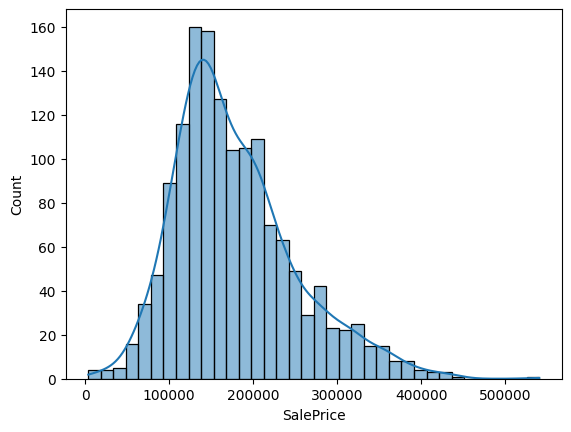

In [92]:
import seaborn as sns
sns.histplot(data=res, x="SalePrice", kde=True)

# Save the model, pre, sel

In [93]:
import joblib

joblib.dump(pre, "pre.joblib")

['pre.joblib']

In [94]:
joblib.dump(sel, "sel.joblib")

['sel.joblib']

In [95]:
joblib.dump(lasso_sel, "lasso_price.joblib")

['lasso_price.joblib']

# Load above files

In [96]:
p = joblib.load("pre.joblib")
p

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [97]:
s = joblib.load("sel.joblib")
s

,estimator,LinearRegression()
,n_features_to_select,'auto'
,tol,None
,direction,'forward'
,scoring,None
,cv,5
,n_jobs,None
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [98]:
m = joblib.load("lasso_price.joblib")
m

,alpha,50
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,42
,selection,'cyclic'


In [99]:
m.score(xtrain_pre_sel, ytrain)

0.8397314603849023

In [100]:
m.score(xtest_pre_sel, ytest)

0.8345584298661639